In [1]:
using AR1
using Color
using Distributions
using Gadfly
using Kepler

 in depwarn at ./deprecated.jl:63
 in require at deprecated.jl:648
 in include at ./boot.jl:254
 in include_from_node1 at ./loading.jl:226
 in require at ./loading.jl:175
 in include at ./boot.jl:254
 in include_from_node1 at ./loading.jl:226
 in require at ./loading.jl:175
 in include_string at loading.jl:188
 in execute_request_0x535c5df2 at /Users/farr/.julia/v0.4/IJulia/src/execute_request.jl:157
 in eventloop at /Users/farr/.julia/v0.4/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:447
while loading /Users/farr/.julia/v0.4/Compose/src/Compose.jl, in expression starting on line 131


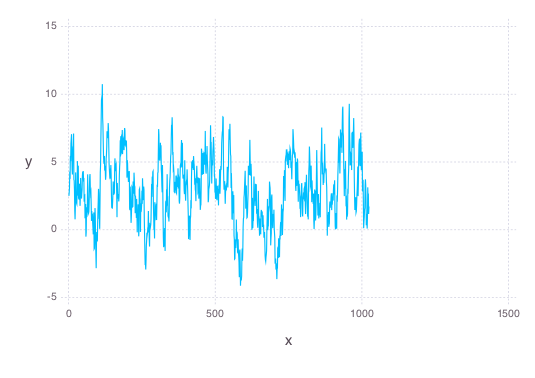

In [12]:
dys = rand(LogNormal(log(0.1), 0.5), 1024)
ys = zeros(1024)
ytrue = 0.0
for i in 1:1024
    ytrue *= exp(-1/10)
    ytrue += randn()
    ys[i] = ytrue + dys[i]*randn() + 3.0
end
plot(x=1:1024, y=ys, Geom.line)

In [13]:
zs, dzs = AR1.residuals(AR1.AR1Model(3.0, sqrt(1.0/(1.0-exp(-2.0/10.0))), 10.0), collect(linspace(1, 1024, 1024)), ys, dys)

([-0.499345,0.200013,0.336355,1.20047,-0.40815,1.75893,-0.151252,1.49424,0.673369,0.713847  …  -2.04973,0.581563,-0.786434,-0.711846,0.67325,1.89651,-0.876494,0.374731,-1.53587,0.347624],[2.35151,1.01396,1.00928,1.00492,1.00525,1.00395,1.0142,1.01348,1.01184,1.00975  …  1.01912,1.00801,1.01325,1.01745,1.01307,1.01059,1.00994,1.008,1.01497,1.01619])

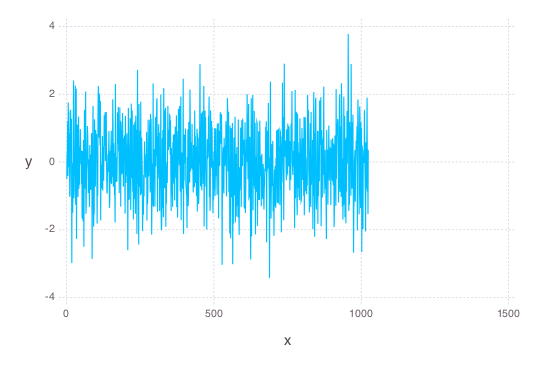

In [14]:
plot(x=1:1024, y=zs, Geom.line)

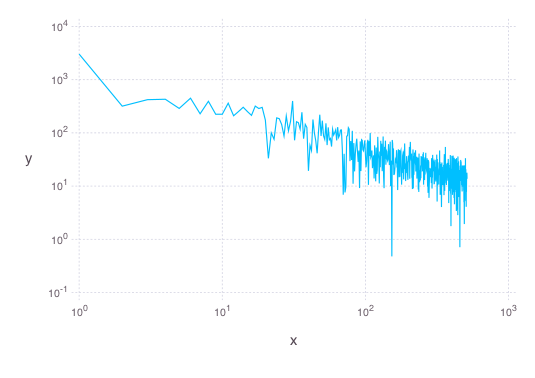

In [20]:
plot(x=1:513, y=abs(rfft(ys)), Geom.line, Scale.y_log10, Scale.x_log10)

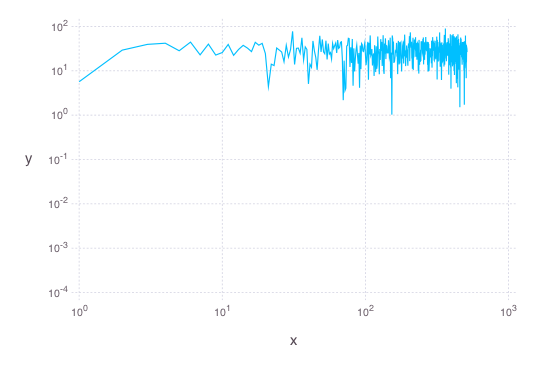

In [21]:
plot(x=1:513, y=abs(rfft(zs/dzs)), Scale.x_log10, Scale.y_log10, Geom.line)